# Problem Statement: Optimal Control for CSTR

We are given the liearized discrete state space model, time horizon, initial state, setpoints for controlled variables, and variable bounds







In [1]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt

from pyomo.environ import *

In [2]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

#### Defining state space model, time horizon, initial state, and variable bounds

Note: since it is assumed that all the states are measurable without noise, here the controlled variables are represented using x instead for simplicity

In [3]:
# linear state-space model
A = np.array(([0.2681,-0.00338,-0.00728],[9.703,0.3279,-25.44],[0,0,1]))
B = np.array(([-0.00537,0.1655],[1.297,97.91],[0,-6.637]))

# time horizon
Np = 3

# initial condition
xinit = [-0.03, 0, 0.3]

# bounds for state and input
x_max = [0.05, 5, 0.5]
x_min = [-0.05, -5, -0.5]
u_max = [10, 0.05]
u_min = [-10, -0.05]


## Model

The LP model for the problem can be derived as follows:


\begin{aligned}
\min_{u(0),u(1),u(2)} \quad &\sum_{k=0}^{k=3} (z_1(k)+z_2(k)) \\
\textit{s.t.} \quad &{x}(k+1) ={A} {x}(k)+{B u}(k) \quad k=0,1,2 \\
&y(k) ={C} {x}(k) \quad k=0,1,2,3 \\
&{x}(0) = \begin{bmatrix}
-0.03 \\
0 \\
0.3
\end{bmatrix} \\
&\begin{bmatrix}
-0.05 \\
-5 \\
-0.5
\end{bmatrix}
\leq x(k) \leq
\begin{bmatrix}
0.05 \\
5 \\
0.5
\end{bmatrix} \quad k=0,1,2,3 \\
&\begin{bmatrix}
-10 \\
-0.05
\end{bmatrix}
\leq u(k) \leq
\begin{bmatrix}
10 \\
0.05
\end{bmatrix} \quad k=0,1,2 \\
&-z_1(k) \leq y_1(k) \leq z_1(k) \quad k=0,1,2,3 \\
&-z_2(k) \leq y_3(k) \leq z_2(k) \quad k=0,1,2,3 \\
\end{aligned}



## Implement

In [4]:
m = ConcreteModel()

#### Initializing Sets

In [5]:
# dimension of state and input
nx = 3
nu = 2

# Define prediction index k and variable sizes
m.k  = RangeSet(0, Np)  # time instants
m.kk = RangeSet(0, Np-1)    # time intervals
m.nx = RangeSet(nx) # x1, x2, x3
m.nu = RangeSet(nu) # u1 and u2
m.nz = RangeSet(2)  # z1 and z2

#### Defining Variables

In [6]:
m.x = Var(m.nx, m.k, initialize=0)
m.u = Var(m.nu, m.kk, initialize=0)
m.z = Var(m.nz, m.k, within=NonNegativeReals)

#### Defining Objective

In [7]:
m.totalCost = sum(m.z[i,k] for i in m.nz for k in m.k)
m.obj = Objective(expr=m.totalCost, sense=minimize)

#### Defining Constraints

In [8]:
# process state space model
m.dynamicsx1 = Constraint(m.kk, rule=lambda m, k:
    m.x[1,k+1] == (A[0,0]*m.x[1,k] + A[0,1]*m.x[2,k] + A[0,2]*m.x[3,k]) + \
        (B[0,0]*m.u[1,k] + B[0,1]*m.u[2,k]))
m.dynamicsx2 = Constraint(m.kk, rule=lambda m, k:
    m.x[2,k+1] == (A[1,0]*m.x[1,k] + A[1,1]*m.x[2,k] + A[1,2]*m.x[3,k]) + \
        (B[1,0]*m.u[1,k] + B[1,1]*m.u[2,k]))
m.dynamicsx3 = Constraint(m.kk, rule=lambda m, k:
    m.x[3,k+1] == (A[2,0]*m.x[1,k] + A[2,1]*m.x[2,k] + A[2,2]*m.x[3,k]) + \
        (B[2,0]*m.u[1,k] + B[2,1]*m.u[2,k]))

# y=Cx is not added here, considering y=x

In [9]:
# fixed initial state
for i in m.nx:
    m.x[i,0].fix(xinit[i-1])

In [10]:
# Constraints on the states and inputs (add bounds)
m.cons = ConstraintList()
for j in m.k:
    for i in m.nx:
        m.cons.add(inequality(x_min[i-1], m.x[i,j], x_max[i-1]))
for j in m.kk:
    for i in m.nu:
        m.cons.add(inequality(u_min[i-1], m.u[i,j], u_max[i-1]))

In [11]:
# additional constraints due to introducing z
# here y1=x1 and y3=x3
m.addcons = ConstraintList()
for i in m.k:
    m.addcons.add(m.z[1,i] >= m.x[1,i])
    m.addcons.add(m.z[1,i] >= -m.x[1,i])
    m.addcons.add(m.z[2,i] >= m.x[3,i])
    m.addcons.add(m.z[2,i] >= -m.x[3,i])

## Solve and Postprocess

In [12]:
sol = SolverFactory('glpk')
results = sol.solve(m)

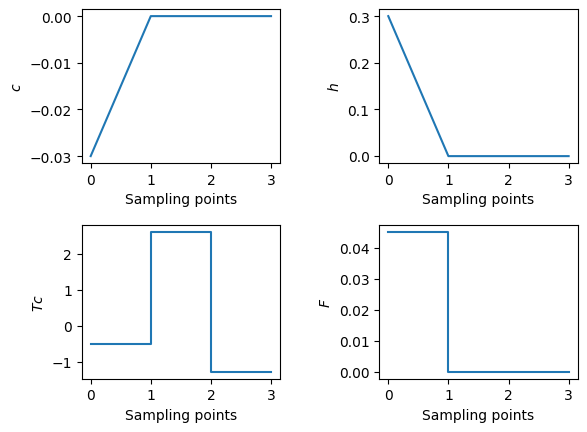

In [13]:
# plot controlled variables and input variables
y1  = [value(m.x[1,k]) for k in m.k]
y2  = [value(m.x[3,k]) for k in m.k]
u1 = [value(m.u[1,k]) for k in m.kk]
u2  = [value(m.u[2,k]) for k in m.kk]


plt.figure()
tx = np.linspace(0,Np,Np+1)
# Subplot - x1
plt.subplot(221)
plt.plot(tx,y1)
plt.ylabel('$c$')
plt.xlabel('Sampling points')
# Subplot - x3
plt.subplot(222)
plt.plot(tx,y2)
plt.ylabel('$h$')
plt.xlabel('Sampling points')
# Subplot - u1
plt.subplot(223)
plt.step(tx, u1 + [u1[-1]], where='post')
plt.ylabel('$Tc$')
plt.xlabel('Sampling points')
# Subplot - u2
plt.subplot(224)
plt.step(tx, u2 + [u2[-1]],where='post')
plt.ylabel('$F$')
plt.xlabel('Sampling points')

plt.subplots_adjust(hspace=0.4, wspace=0.5)

plt.show()
